In [1]:
!pip install transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
!pip install ace_tools

**Cross-lingual transferability:** train your model on high resource language like english and evaluate on low resource languages like arabic and swahili.

Select a downstream task like text classification

Use bloom-560m model for tokenization and model training

In [3]:
# Import necessary libraries
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import torch

# Step 1: Load the XNLI dataset

# Training data: English
train_dataset = load_dataset('xnli', 'en', split='train')

# Evaluation data: English, Arabic, Swahili
eval_datasets = {}
for lang in ['en', 'ar', 'sw']:
    eval_datasets[lang] = load_dataset('xnli', lang, split='validation')

# Step 2: Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('bigscience/bloom-560m')
model = AutoModelForSequenceClassification.from_pretrained('bigscience/bloom-560m', num_labels=3)

# Step 3: Preprocess data
def preprocess_function(examples):
    # Tokenize the inputs
    return tokenizer(examples['premise'], examples['hypothesis'], truncation=True, padding='max_length', max_length=128)

# Apply preprocessing to datasets
train_dataset = train_dataset.map(preprocess_function, batched=True)
for lang in eval_datasets:
    eval_datasets[lang] = eval_datasets[lang].map(preprocess_function, batched=True)

# Step 4: Prepare for training
# Set the format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
for lang in eval_datasets:
    eval_datasets[lang].set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# For faster processing, select subsets
train_dataset = train_dataset.shuffle(seed=42).select(range(min(10000, len(train_dataset))))
for lang in eval_datasets:
    eval_datasets[lang] = eval_datasets[lang].shuffle(seed=42).select(range(min(1000, len(eval_datasets[lang]))))

# Step 5: Define compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {'accuracy': acc, 'f1': f1}

# Step 6: Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    evaluation_strategy='no',
    save_strategy='no',
    logging_dir='./logs',
    gradient_accumulation_steps=16,
    fp16=True,
)

# Step 7: Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    compute_metrics=compute_metrics,
)

# Step 8: Train the model
torch.cuda.empty_cache()
trainer.train()

# Step 9: Evaluate on English, Arabic, and Swahili
results = {}
for lang in ['en', 'ar', 'sw']:
    print(f"\nEvaluating on {lang.upper()} Validation Set...")
    metrics = trainer.evaluate(eval_dataset=eval_datasets[lang])
    print(f"{lang.upper()} Evaluation Metrics: {metrics}")
    results[lang] = metrics

# Step 10: Compute transfer efficiency
english_accuracy = results['en']['eval_accuracy']
arabic_accuracy = results['ar']['eval_accuracy']
swahili_accuracy = results['sw']['eval_accuracy']
english_f1 = results['en']['eval_f1']
arabic_f1 = results['ar']['eval_f1']
swahili_f1 = results['sw']['eval_f1']

arabic_transfer_efficiency = arabic_accuracy / english_accuracy if english_accuracy != 0 else 0
swahili_transfer_efficiency = swahili_accuracy / english_accuracy if english_accuracy != 0 else 0

print(f"\nArabic Transfer Efficiency: {arabic_transfer_efficiency:.2f}")
print(f"Swahili Transfer Efficiency: {swahili_transfer_efficiency:.2f}")

# Step 11: Summarize and visualize results
languages = ['English', 'Arabic', 'Swahili']
accuracies = [english_accuracy, arabic_accuracy, swahili_accuracy]

# Print results
print("\nFinal Results:")
for lang, acc in zip(languages, accuracies):
    print(f"{lang} Accuracy: {acc:.2f}")

# Save results
final_results = {
    'English Accuracy': english_accuracy,
    'Arabic Accuracy': arabic_accuracy,
    'Swahili Accuracy': swahili_accuracy,
    'English F1 Score': english_f1,
    'Arabic F1 Score': arabic_f1,
    'Swahili F1 Score': swahili_f1,
    'Arabic Transfer Efficiency': arabic_transfer_efficiency,
    'Swahili Transfer Efficiency': swahili_transfer_efficiency,
}

import json
with open('task3_results.json', 'w') as f:
    json.dump(final_results, f, indent=4)

print("\nResults saved to task3_results.json")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/50.2M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/308k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/157k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5010 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2490 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/58.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/392k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/194k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5010 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2490 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/45.1M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/312k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/158k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5010 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2490 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of BloomForSequenceClassification were not initialized from the model checkpoint at bigscience/bloom-560m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/392702 [00:00<?, ? examples/s]

Map:   0%|          | 0/2490 [00:00<?, ? examples/s]

Map:   0%|          | 0/2490 [00:00<?, ? examples/s]

Map:   0%|          | 0/2490 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
500,2.242400



Evaluating on EN Validation Set...


EN Evaluation Metrics: {'eval_loss': 0.7244116067886353, 'eval_accuracy': 0.702, 'eval_f1': 0.702434066958095, 'eval_runtime': 29.9822, 'eval_samples_per_second': 33.353, 'eval_steps_per_second': 33.353, 'epoch': 1.0}

Evaluating on AR Validation Set...
AR Evaluation Metrics: {'eval_loss': 0.9054737687110901, 'eval_accuracy': 0.593, 'eval_f1': 0.5895884268624383, 'eval_runtime': 36.0862, 'eval_samples_per_second': 27.711, 'eval_steps_per_second': 27.711, 'epoch': 1.0}

Evaluating on SW Validation Set...
SW Evaluation Metrics: {'eval_loss': 1.0581417083740234, 'eval_accuracy': 0.497, 'eval_f1': 0.49355697307431595, 'eval_runtime': 34.1465, 'eval_samples_per_second': 29.286, 'eval_steps_per_second': 29.286, 'epoch': 1.0}

Arabic Transfer Efficiency: 0.84
Swahili Transfer Efficiency: 0.71

Final Results:
English Accuracy: 0.70
Arabic Accuracy: 0.59
Swahili Accuracy: 0.50

Results saved to task3_results.json


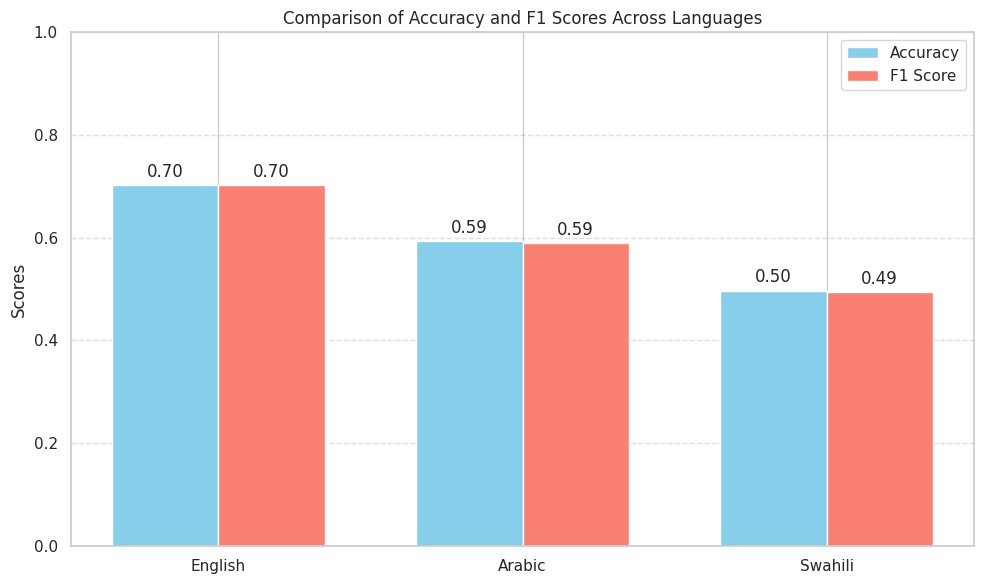

<ipython-input-4-55bd0aa75fcb>:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=languages_with_en, y=transfer_efficiencies, palette='magma')


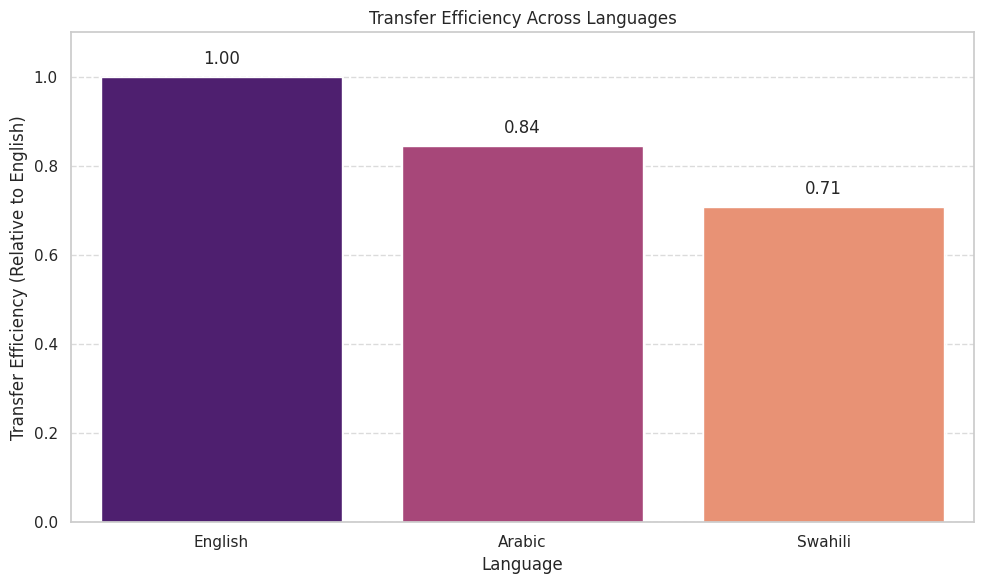


Performance Table:
Language  Accuracy  F1 Score  Transfer Efficiency (Relative to English)
 English     0.702  0.702434                                   1.000000
  Arabic     0.593  0.589588                                   0.844729
 Swahili     0.497  0.493557                                   0.707977


In [4]:
# Import necessary libraries for plotting
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Set Seaborn style for better aesthetics
sns.set(style="whitegrid")

# Define visualization variables
languages = ['English', 'Arabic', 'Swahili']
accuracies = [english_accuracy, arabic_accuracy, swahili_accuracy]
f1_scores = [results['en']['eval_f1'], results['ar']['eval_f1'], results['sw']['eval_f1']]

# Define transfer efficiencies (English set to 1.0 as baseline)
transfer_efficiencies = [1.0, arabic_transfer_efficiency, swahili_transfer_efficiency]

# Plotting Bar Chart for Accuracy and F1 Scores
x = np.arange(len(languages))
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, accuracies, width, label='Accuracy', color='skyblue')
rects2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score', color='salmon')

# Add grid lines for better readability
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.25)

# Add labels, title, and legend
ax.set_ylabel('Scores')
ax.set_title('Comparison of Accuracy and F1 Scores Across Languages')
ax.set_xticks(x)
ax.set_xticklabels(languages)
ax.legend()

# Add numerical values on top of bars
def autolabel(rects, fmt='.2f'):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:{fmt}}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Offset text by 3 points vertically
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1, fmt='.2f')
autolabel(rects2, fmt='.2f')

plt.ylim(0, 1)  # Set Y-axis from 0 to 1 for raw decimal values
plt.tight_layout()
plt.show()

# Plotting Bar Chart for Transfer Efficiencies
languages_with_en = ['English', 'Arabic', 'Swahili']

plt.figure(figsize=(10, 6))
sns.barplot(x=languages_with_en, y=transfer_efficiencies, palette='magma')

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.ylim(0, max(transfer_efficiencies) + 0.1)  # Adjust Y-axis to accommodate labels
plt.title('Transfer Efficiency Across Languages')
plt.ylabel('Transfer Efficiency (Relative to English)')
plt.xlabel('Language')

# Add efficiency labels on top of bars
for index, value in enumerate(transfer_efficiencies):
    plt.text(index, value + 0.02, f"{value:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Prepare data for table
data = {
    'Language': languages,
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Transfer Efficiency (Relative to English)': transfer_efficiencies
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Display the table with raw decimal values
print("\nPerformance Table:")
print(df.to_string(index=False))


In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import torch
import json

# Step 1: Load the XNLI dataset
train_dataset = load_dataset('xnli', 'en', split='train')

eval_datasets = {}
for lang in ['en', 'ar', 'sw']:
    eval_datasets[lang] = load_dataset('xnli', lang, split='validation')

# Step 2: Load the tokenizer and model
model_name = 'bert-base-multilingual-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# Step 3: Preprocess the data
def preprocess_function(examples):
    return tokenizer(examples['premise'], examples['hypothesis'], truncation=True, padding='max_length', max_length=128)

train_dataset = train_dataset.map(preprocess_function, batched=True)
for lang in eval_datasets:
    eval_datasets[lang] = eval_datasets[lang].map(preprocess_function, batched=True)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
for lang in eval_datasets:
    eval_datasets[lang].set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

train_dataset = train_dataset.shuffle(seed=42).select(range(min(10000, len(train_dataset))))
for lang in eval_datasets:
    eval_datasets[lang] = eval_datasets[lang].shuffle(seed=42).select(range(min(1000, len(eval_datasets[lang]))))

# Step 4: Define compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {'accuracy': acc, 'f1': f1}

# Step 5: Define training arguments
training_args = TrainingArguments(
    output_dir='./results_bert_multilingual',
    num_train_epochs=1,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    evaluation_strategy='no',
    save_strategy='no',
    logging_dir='./logs_bert_multilingual',
    gradient_accumulation_steps=4,
    fp16=True,
)

# Step 6: Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    compute_metrics=compute_metrics,
)

# Step 7: Train the model
torch.cuda.empty_cache()
trainer.train()

# Step 8: Evaluate on English, Arabic, and Swahili
results = {}
for lang in ['en', 'ar', 'sw']:
    print(f"\nEvaluating on {lang.upper()} Validation Set...")
    metrics = trainer.evaluate(eval_dataset=eval_datasets[lang])
    print(f"{lang.upper()} Evaluation Metrics: {metrics}")
    results[lang] = metrics

# Step 9: Compute transfer efficiency
english_accuracy = results['en']['eval_accuracy']
arabic_accuracy = results['ar']['eval_accuracy']
swahili_accuracy = results['sw']['eval_accuracy']
english_f1 = results['en']['eval_f1']
arabic_f1 = results['ar']['eval_f1']
swahili_f1 = results['sw']['eval_f1']

arabic_transfer_efficiency = arabic_accuracy / english_accuracy if english_accuracy != 0 else 0
swahili_transfer_efficiency = swahili_accuracy / english_accuracy if english_accuracy != 0 else 0

print(f"\nArabic Transfer Efficiency: {arabic_transfer_efficiency:.2f}")
print(f"Swahili Transfer Efficiency: {swahili_transfer_efficiency:.2f}")

# Step 10: Save results
final_results = {
    'English Accuracy': english_accuracy,
    'Arabic Accuracy': arabic_accuracy,
    'Swahili Accuracy': swahili_accuracy,
    'English F1 Score': english_f1,
    'Arabic F1 Score': arabic_f1,
    'Swahili F1 Score': swahili_f1,
    'Arabic Transfer Efficiency': arabic_transfer_efficiency,
    'Swahili Transfer Efficiency': swahili_transfer_efficiency,
}

with open('bert_multilingual_results.json', 'w') as f:
    json.dump(final_results, f, indent=4)

print("\nResults saved to bert_multilingual_results.json")


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/392702 [00:00<?, ? examples/s]

Map:   0%|          | 0/2490 [00:00<?, ? examples/s]

Map:   0%|          | 0/2490 [00:00<?, ? examples/s]

Map:   0%|          | 0/2490 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss
500,1.100100



Evaluating on EN Validation Set...


EN Evaluation Metrics: {'eval_loss': 0.9968896508216858, 'eval_accuracy': 0.543, 'eval_f1': 0.5427293526136459, 'eval_runtime': 3.5261, 'eval_samples_per_second': 283.597, 'eval_steps_per_second': 70.899, 'epoch': 1.0}

Evaluating on AR Validation Set...
AR Evaluation Metrics: {'eval_loss': 1.0403032302856445, 'eval_accuracy': 0.474, 'eval_f1': 0.457022783105828, 'eval_runtime': 5.1621, 'eval_samples_per_second': 193.718, 'eval_steps_per_second': 48.43, 'epoch': 1.0}

Evaluating on SW Validation Set...
SW Evaluation Metrics: {'eval_loss': 1.0962646007537842, 'eval_accuracy': 0.399, 'eval_f1': 0.3013079191055156, 'eval_runtime': 4.6606, 'eval_samples_per_second': 214.564, 'eval_steps_per_second': 53.641, 'epoch': 1.0}

Arabic Transfer Efficiency: 0.87
Swahili Transfer Efficiency: 0.73

Results saved to bert_multilingual_results.json


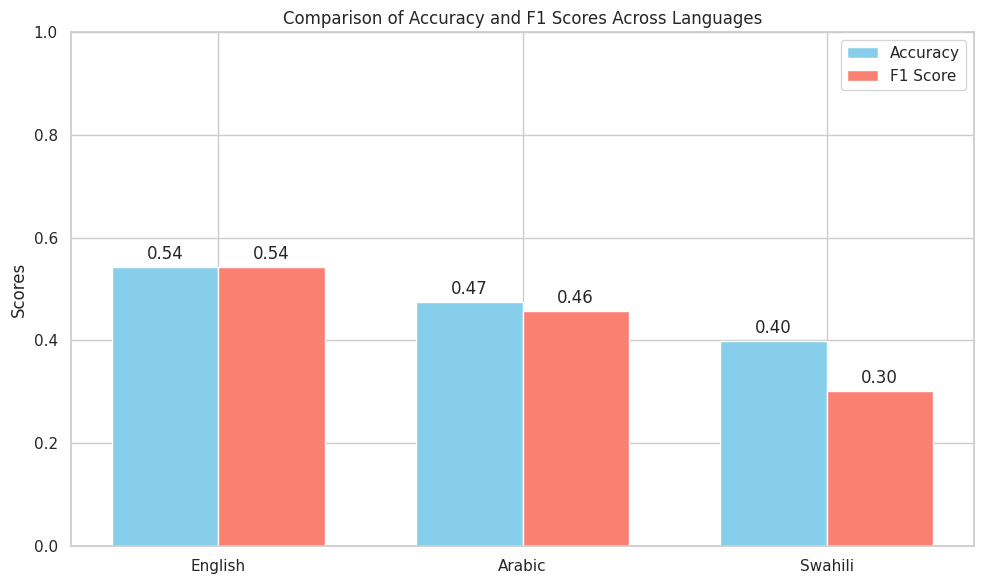

<ipython-input-6-5d545939f1e4>:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=languages_with_en, y=transfer_efficiencies, palette='magma')


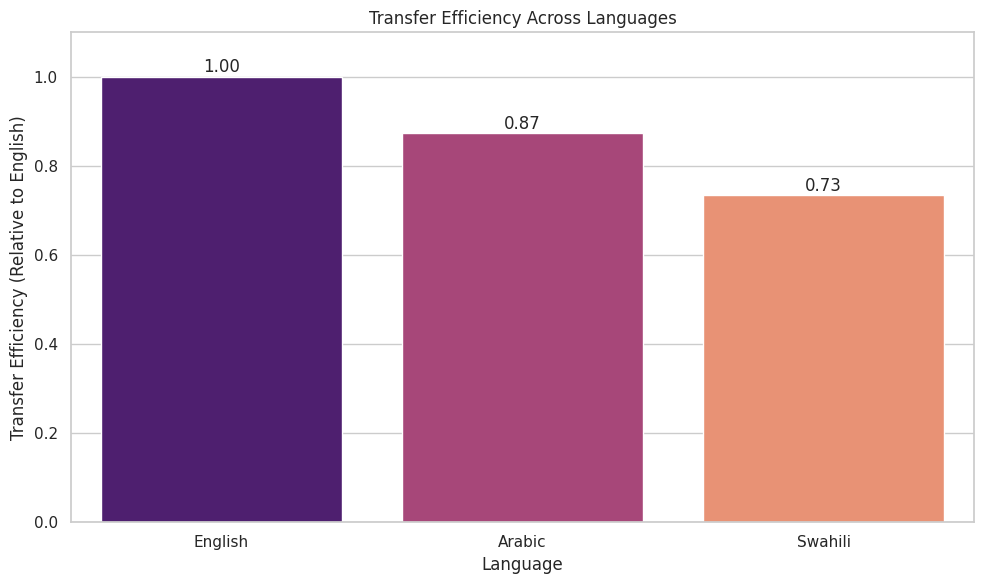


Performance Table:
Language  Accuracy  F1 Score  Transfer Efficiency (Relative to English)
 English     0.543  0.542729                                   1.000000
  Arabic     0.474  0.457023                                   0.872928
 Swahili     0.399  0.301308                                   0.734807


In [6]:
# Import necessary libraries for plotting
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Define visualization variables
languages = ['English', 'Arabic', 'Swahili']
accuracies = [english_accuracy, arabic_accuracy, swahili_accuracy]
f1_scores = [results['en']['eval_f1'], results['ar']['eval_f1'], results['sw']['eval_f1']]

# Plotting Bar Chart for Accuracy and F1 Scores
x = np.arange(len(languages))
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, accuracies, width, label='Accuracy', color='skyblue')
rects2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score', color='salmon')

# Add labels, title, and legend
ax.set_ylabel('Scores')
ax.set_title('Comparison of Accuracy and F1 Scores Across Languages')
ax.set_xticks(x)
ax.set_xticklabels(languages)
ax.legend()

# Add numerical values on top of bars
def autolabel(rects, fmt='.2f'):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:{fmt}}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # Offset text by 3 points vertically
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.ylim(0, 1)  # Set Y-axis from 0 to 1
plt.tight_layout()
plt.show()

# Plotting Bar Chart for Transfer Efficiencies
transfer_efficiencies = [1.0, arabic_transfer_efficiency, swahili_transfer_efficiency]  # English set to 1.0
languages_with_en = ['English', 'Arabic', 'Swahili']

plt.figure(figsize=(10, 6))
sns.barplot(x=languages_with_en, y=transfer_efficiencies, palette='magma')
plt.ylim(0, max(transfer_efficiencies) + 0.1)  # Adjust Y-axis to accommodate labels
plt.title('Transfer Efficiency Across Languages')
plt.ylabel('Transfer Efficiency (Relative to English)')
plt.xlabel('Language')

# Add efficiency labels on top of bars
for index, value in enumerate(transfer_efficiencies):
    plt.text(index, value + 0.01, f"{value:.2f}", ha='center')

plt.tight_layout()
plt.show()

# Prepare data for table
data = {
    'Language': languages,
    'Accuracy': accuracies,
    'F1 Score': f1_scores,
    'Transfer Efficiency (Relative to English)': transfer_efficiencies
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Display the table
print("\nPerformance Table:")
print(df.to_string(index=False))


In [8]:
import json

# Load BLOOM-560m results
with open('task3_results.json', 'r') as f:
    bloom_results = json.load(f)

# Load BERT-base Multilingual Cased results
with open('bert_multilingual_results.json', 'r') as f:
    bert_results = json.load(f)


In [9]:
import pandas as pd

# Define the languages
languages = ['English', 'Arabic', 'Swahili']

# Create a DataFrame for BLOOM-560m
bloom_data = {
    'Model': 'BLOOM-560m',
    'Language': languages,
    'Accuracy': [
        bloom_results.get('English Accuracy', None),
        bloom_results.get('Arabic Accuracy', None),
        bloom_results.get('Swahili Accuracy', None)
    ],
    'F1 Score': [
        bloom_results.get('English F1 Score', None),
        bloom_results.get('Arabic F1 Score', None),
        bloom_results.get('Swahili F1 Score', None)
    ],
    'Transfer Efficiency (Accuracy)': [
        1.0,  # English is the high-resource language
        bloom_results.get('Arabic Transfer Efficiency', None),
        bloom_results.get('Swahili Transfer Efficiency', None)
    ]
}

# Create a DataFrame for BERT-base Multilingual Cased
bert_data = {
    'Model': 'BERT-base Multilingual Cased',
    'Language': languages,
    'Accuracy': [
        bert_results.get('English Accuracy', None),
        bert_results.get('Arabic Accuracy', None),
        bert_results.get('Swahili Accuracy', None)
    ],
    'F1 Score': [
        bert_results.get('English F1 Score', None),
        bert_results.get('Arabic F1 Score', None),
        bert_results.get('Swahili F1 Score', None)
    ],
    'Transfer Efficiency (Accuracy)': [
        1.0,  # English is the high-resource language
        bert_results.get('Arabic Transfer Efficiency', None),
        bert_results.get('Swahili Transfer Efficiency', None)
    ]
}

# Convert dictionaries to DataFrames
df_bloom = pd.DataFrame(bloom_data)
df_bert = pd.DataFrame(bert_data)

# Combine both DataFrames
df_comparison = pd.concat([df_bloom, df_bert], ignore_index=True)

# Display the combined DataFrame
print("\nComparative Performance Table:")
print(df_comparison)



Comparative Performance Table:
                          Model Language  Accuracy  F1 Score  \
0                    BLOOM-560m  English     0.702  0.702434   
1                    BLOOM-560m   Arabic     0.593  0.589588   
2                    BLOOM-560m  Swahili     0.497  0.493557   
3  BERT-base Multilingual Cased  English     0.543  0.542729   
4  BERT-base Multilingual Cased   Arabic     0.474  0.457023   
5  BERT-base Multilingual Cased  Swahili     0.399  0.301308   

   Transfer Efficiency (Accuracy)  
0                        1.000000  
1                        0.844729  
2                        0.707977  
3                        1.000000  
4                        0.872928  
5                        0.734807  


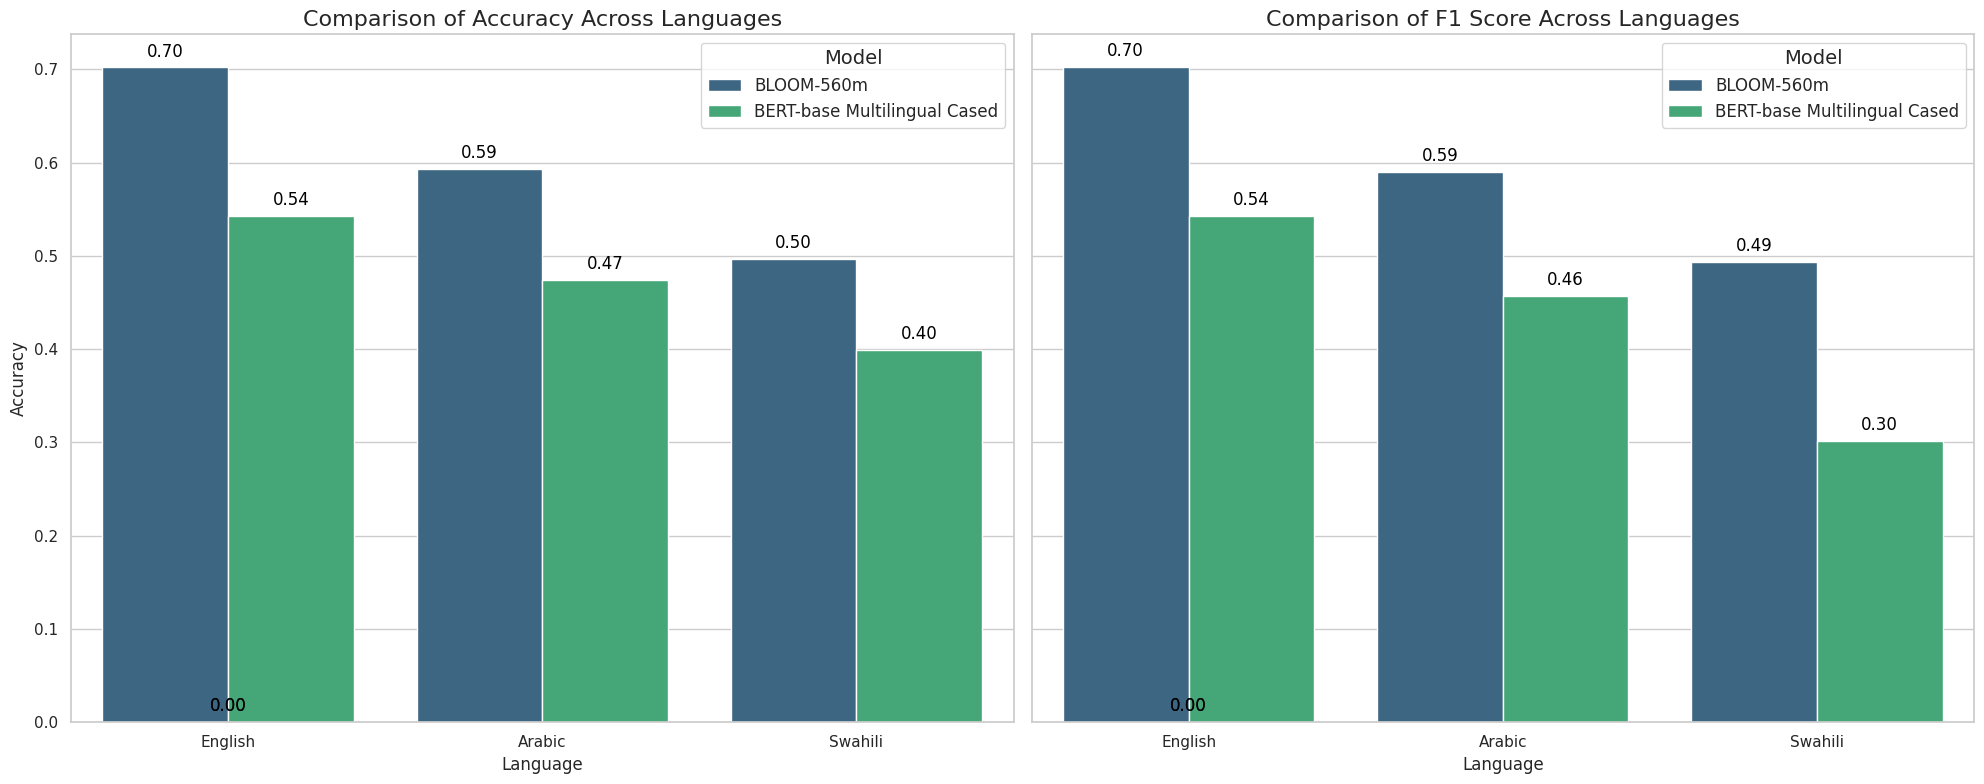

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set Seaborn style for better aesthetics
sns.set(style="whitegrid")

# Define the metrics to plot
metrics = ['Accuracy', 'F1 Score']
models = df_comparison['Model'].unique()

# Initialize the plot
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

for ax, metric in zip(axes, metrics):
    sns.barplot(
        data=df_comparison,
        x='Language',
        y=metric,
        hue='Model',
        palette='viridis',
        ax=ax
    )
    ax.set_title(f'Comparison of {metric} Across Languages', fontsize=16)
    ax.set_ylabel(metric)
    ax.set_xlabel('Language')
    ax.legend(title='Model', fontsize=12, title_fontsize=14)

    # Add numerical values on top of bars
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom',
                    fontsize=12, color='black', xytext=(0, 5),
                    textcoords='offset points')

plt.tight_layout()
plt.show()
